In [1]:
!pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 762.9 kB/s eta 0:00:00


We import the libraries that we are going to use

In [55]:
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, GRU, Dense
from keras.layers import Flatten, Conv1D, ConvLSTM2D
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import check_array

We show the dataset which will get used for this code

In [3]:
table = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
table[0]

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


We print the columns of our dataset

In [4]:
print(df.columns)

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='object')


We split the datapoints that are from before 2010

In [5]:
date_filter = [datetime.strptime(dt, '%Y-%m-%d') < datetime(2010, 1, 1) for dt in df['Date added']]
New_table = df[date_filter]

In [6]:
New_table

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
5,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
8,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
...,...,...,...,...,...,...,...,...
495,WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,"Paradise, Nevada",2008-11-14,1174922,2002
496,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [7]:
print(New_table.columns)

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='object')


Now we download the dataset for the Tickers we want to use

In [9]:
My_Tickers = ["GOOGL","AAPL","AMZN","MSFT","META"]
Raw_Price_For_My_Tickers = yf.download(tickers = My_Tickers, start = "2010-01-04", interval =   "1d", group_by = 'ticker')
Raw_Price_For_My_Tickers

[*********************100%%**********************]  5 of 5 completed


AMZN                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                ...         ...         ...         ...         ...   
2023-12-21  153.300003  153.970001  152.100006  153.839996  153.839996   
2023-12-22  153.770004  154.350006  152.710007  153.419998  153.419998   
2023-12-26  153.559998  153.979996  153.029999  153.410004  153.410004   
2023-12-27  153.559998  154.779999  153.119995  153.339996  153.339996   
2023-12-28  153.720001  154.080002  152.949997  153.380005  153.380005   

                             AAPL                                      ...  \
               Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2010-01-04  151998000    7.622500    7.660714    7.585000    7.643214  ...   
2010-01-05  177038000    7.664286    7.699643    7.616071    7.656429  ...   
2010-01-06  143576000    7.656429    7.686786    7.526786    7.534643  ...   
2010-01-07  220604000    7.562500    7.571429    7.466071    7.520714  ...   
2010-01-08  196610000    7.510714    7.571429    7.466429    7.570714  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-21   36305700  196.100006  197.080002  193.500000  194.679993  ...   
2023-12-22   29480100  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   25067200  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   31434700  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   27031200  194.139999  194.660004  193.169998  193.580002  ...   

                  MSFT                                          META  \
                   Low       Close   Adj Close    Volume        Open   
Date                                                                   
2010-01-04   30.590000   30.950001   23.474916  38409100         NaN   
2010-01-05   30.639999   30.959999   23.482510  49749600         NaN   
2010-01-06   30.520000   30.770000   23.338396  58182400         NaN   
2010-01-07   30.190001   30.450001   23.095682  50559700         NaN   
2010-01-08   30.240000   30.660000   23.254955  51197400         NaN   
...                ...         ...         ...       ...         ...   
2023-12-21  370.040009  373.540009  373.540009  17708000  352.980011   
2023-12-22  372.709991  374.579987  374.579987  17091100  355.579987   
2023-12-26  373.500000  374.660004  374.660004  12673100  354.989990   
2023-12-27  372.809998  374.070007  374.070007  14905400  356.070007   
2023-12-28  374.160004  375.279999  375.279999  14298000  359.700012   

                                                                        
                  High         Low       Close   Adj Close      Volume  
Date                                                                    
2010-01-04         NaN         NaN         NaN         NaN         NaN  
2010-01-05         NaN         NaN         NaN         NaN         NaN  
2010-01-06         NaN         NaN         NaN         NaN         NaN  
2010-01-07         NaN         NaN         NaN         NaN         NaN  
2010-01-08         NaN         NaN         NaN         NaN         NaN  
...                ...         ...         ...         ...         ...  
2023-12-21  356.410004  349.209991  354.089996  354.089996  15289600.0  
2023-12-22  357.200012  351.220001  353.390015  353.390015  11764200.0  
2023-12-26  356.980011  353.450012  354.829987  354.829987   9898600.0  
202

In [10]:
type(Raw_Price_For_My_Tickers)

pandas.core.frame.DataFrame

In [11]:
print(Raw_Price_For_My_Tickers.columns)

MultiIndex([( 'AMZN',      'Open'),
            ( 'AMZN',      'High'),
            ( 'AMZN',       'Low'),
            ( 'AMZN',     'Close'),
            ( 'AMZN', 'Adj Close'),
            ( 'AMZN',    'Volume'),
            ( 'AAPL',      'Open'),
            ( 'AAPL',      'High'),
            ( 'AAPL',       'Low'),
            ( 'AAPL',     'Close'),
            ( 'AAPL', 'Adj Close'),
            ( 'AAPL',    'Volume'),
            ('GOOGL',      'Open'),
            ('GOOGL',      'High'),
            ('GOOGL',       'Low'),
            ('GOOGL',     'Close'),
            ('GOOGL', 'Adj Close'),
            ('GOOGL',    'Volume'),
            ( 'MSFT',      'Open'),
            ( 'MSFT',      'High'),
            ( 'MSFT',       'Low'),
            ( 'MSFT',     'Close'),
            ( 'MSFT', 'Adj Close'),
            ( 'MSFT',    'Volume'),
            ( 'META',      'Open'),
            ( 'META',      'High'),
            ( 'META',       'Low'),
            ( 'META',     'C

We employ three different filling concepts for our dataset. Depending on whether the null value is at the beginning, middle, or end of the dataset, the method applied would be different.

In [12]:
# Handling missing values in Raw_Price_For_My_Tickers
# 1. Forward fill missing values at the beginning
Raw_Price_For_My_Tickers_filled = Raw_Price_For_My_Tickers.ffill()

# 2. Linear interpolation for missing values in the middle
Raw_Price_For_My_Tickers_filled = Raw_Price_For_My_Tickers.interpolate(method='linear')

# 3. Backward fill missing values at the end
Raw_Price_For_My_Tickers_filled = Raw_Price_For_My_Tickers.bfill()

In [13]:
# Displaying the resulting DataFrame
Raw_Price_For_My_Tickers_filled

AMZN                                                  \
                  Open        High         Low       Close   Adj Close   
Date                                                                     
2010-01-04    6.812500    6.830500    6.657000    6.695000    6.695000   
2010-01-05    6.671500    6.774000    6.590500    6.734500    6.734500   
2010-01-06    6.730000    6.736500    6.582500    6.612500    6.612500   
2010-01-07    6.600500    6.616000    6.440000    6.500000    6.500000   
2010-01-08    6.528000    6.684000    6.451500    6.676000    6.676000   
...                ...         ...         ...         ...         ...   
2023-12-21  153.300003  153.970001  152.100006  153.839996  153.839996   
2023-12-22  153.770004  154.350006  152.710007  153.419998  153.419998   
2023-12-26  153.559998  153.979996  153.029999  153.410004  153.410004   
2023-12-27  153.559998  154.779999  153.119995  153.339996  153.339996   
2023-12-28  153.720001  154.080002  152.949997  153.380005  153.380005   

                             AAPL                                      ...  \
               Volume        Open        High         Low       Close  ...   
Date                                                                   ...   
2010-01-04  151998000    7.622500    7.660714    7.585000    7.643214  ...   
2010-01-05  177038000    7.664286    7.699643    7.616071    7.656429  ...   
2010-01-06  143576000    7.656429    7.686786    7.526786    7.534643  ...   
2010-01-07  220604000    7.562500    7.571429    7.466071    7.520714  ...   
2010-01-08  196610000    7.510714    7.571429    7.466429    7.570714  ...   
...               ...         ...         ...         ...         ...  ...   
2023-12-21   36305700  196.100006  197.080002  193.500000  194.679993  ...   
2023-12-22   29480100  195.179993  195.410004  192.970001  193.600006  ...   
2023-12-26   25067200  193.610001  193.889999  192.830002  193.050003  ...   
2023-12-27   31434700  192.490005  193.500000  191.089996  193.149994  ...   
2023-12-28   27031200  194.139999  194.660004  193.169998  193.580002  ...   

                  MSFT                                          META  \
                   Low       Close   Adj Close    Volume        Open   
Date                                                                   
2010-01-04   30.590000   30.950001   23.474916  38409100   42.049999   
2010-01-05   30.639999   30.959999   23.482510  49749600   42.049999   
2010-01-06   30.520000   30.770000   23.338396  58182400   42.049999   
2010-01-07   30.190001   30.450001   23.095682  50559700   42.049999   
2010-01-08   30.240000   30.660000   23.254955  51197400   42.049999   
...                ...         ...         ...       ...         ...   
2023-12-21  370.040009  373.540009  373.540009  17708000  352.980011   
2023-12-22  372.709991  374.579987  374.579987  17091100  355.579987   
2023-12-26  373.500000  374.660004  374.660004  12673100  354.989990   
2023-12-27  372.809998  374.070007  374.070007  14905400  356.070007   
2023-12-28  374.160004  375.279999  375.279999  14298000  359.700012   

                                                                         
                  High         Low       Close   Adj Close       Volume  
Date                                                                     
2010-01-04   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-05   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-06   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-07   45.000000   38.000000   38.230000   38.230000  573576400.0  
2010-01-08   45.000000   38.000000   38.230000   38.230000  573576400.0  
...                ...         ...         ...         ...          ...  
2023-12-21  356.410004  349.209991  354.089996  354.089996   15289600.0  
2023-12-22  357.200012  351.220001  353.390015  353.390015   11764200.0  
2023-12-26  356.980011  353.450012  354.829987  354.829987    989

We check to see if the data has any NaN values or not

In [14]:
any_nan_values = Raw_Price_For_My_Tickers_filled.isna().any().any()

if any_nan_values:
    print("There are NaN values in the DataFrame.")
else:
    print("There are no NaN values in the DataFrame.")

There are no NaN values in the DataFrame.


In [15]:
print(Raw_Price_For_My_Tickers_filled.columns)

MultiIndex([( 'AMZN',      'Open'),
            ( 'AMZN',      'High'),
            ( 'AMZN',       'Low'),
            ( 'AMZN',     'Close'),
            ( 'AMZN', 'Adj Close'),
            ( 'AMZN',    'Volume'),
            ( 'AAPL',      'Open'),
            ( 'AAPL',      'High'),
            ( 'AAPL',       'Low'),
            ( 'AAPL',     'Close'),
            ( 'AAPL', 'Adj Close'),
            ( 'AAPL',    'Volume'),
            ('GOOGL',      'Open'),
            ('GOOGL',      'High'),
            ('GOOGL',       'Low'),
            ('GOOGL',     'Close'),
            ('GOOGL', 'Adj Close'),
            ('GOOGL',    'Volume'),
            ( 'MSFT',      'Open'),
            ( 'MSFT',      'High'),
            ( 'MSFT',       'Low'),
            ( 'MSFT',     'Close'),
            ( 'MSFT', 'Adj Close'),
            ( 'MSFT',    'Volume'),
            ( 'META',      'Open'),
            ( 'META',      'High'),
            ( 'META',       'Low'),
            ( 'META',     'C

We plot the histogram for AMZN ticker

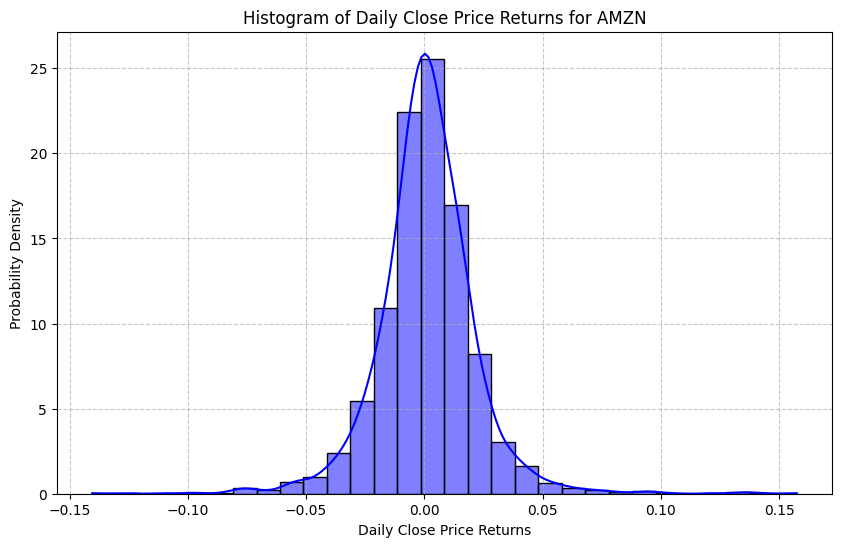

In [16]:
# Extract data for the selected ticker
selected_ticker = "AMZN"
close_prices = Raw_Price_For_My_Tickers_filled[selected_ticker]['Close']

# Calculate daily close price returns
daily_returns = close_prices.pct_change()

# Plot histogram of close price returns with PDF
plt.figure(figsize=(10, 6))
sns.histplot(daily_returns, kde=True, color='blue',bins=30,  stat='density')
plt.title(f'Histogram of Daily Close Price Returns for {selected_ticker}')
plt.xlabel('Daily Close Price Returns')
plt.ylabel('Probability Density')
# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [17]:
Raw_Price_For_Selected_Ticker = Raw_Price_For_My_Tickers_filled[selected_ticker]
print(Raw_Price_For_Selected_Ticker.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


We use MLP Finance to plot our data in candle style. The reason the candles aren't visible, and it appears more like a linear style, is that the dataset is quite large for the plot to handle. Because of this, the candles cannot be easily seen with the naked eye.

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


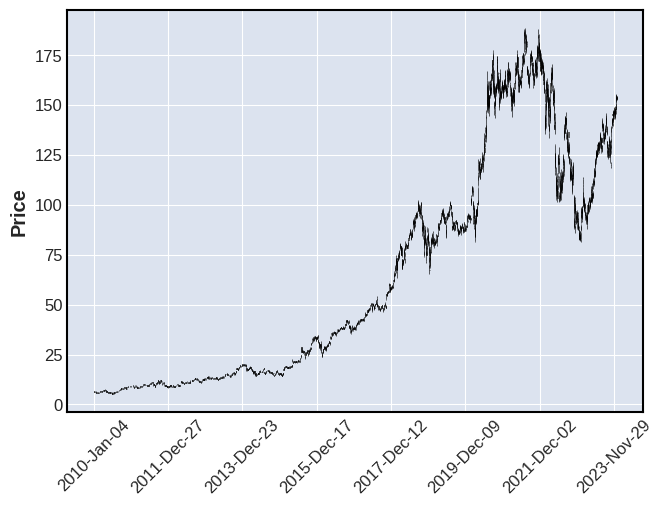

In [18]:
mpf.plot(Raw_Price_For_Selected_Ticker , type='candle')

We define tss for cross validation

In [39]:
cv_n_splits = 5
tss = TimeSeriesSplit(n_splits = cv_n_splits)

We perform normalization on our data with the help of MinMaxScaler

In [20]:
data = MinMaxScaler().fit_transform(Raw_Price_For_My_Tickers_filled)

In [21]:
data = pd.DataFrame(data, columns=Raw_Price_For_My_Tickers_filled.columns)

In [22]:
data

AMZN                                                        AAPL  \
          Open      High       Low     Close Adj Close    Volume      Open   
0     0.008334  0.006915  0.007614  0.006981  0.006981  0.161739  0.003935   
1     0.007559  0.006606  0.007243  0.007199  0.007199  0.191879  0.004153   
2     0.007881  0.006401  0.007199  0.006525  0.006525  0.151602  0.004112   
3     0.007169  0.005743  0.006405  0.005904  0.005904  0.244317  0.003621   
4     0.006770  0.006114  0.006469  0.006876  0.006876  0.215437  0.003350   
...        ...       ...       ...       ...       ...       ...       ...   
3516  0.813637  0.810563  0.817658  0.819308  0.819308  0.022484  0.989956   
3517  0.816221  0.812638  0.821055  0.816990  0.816990  0.014268  0.985142   
3518  0.815067  0.810617  0.822837  0.816934  0.816934  0.008957  0.976929   
3519  0.815067  0.814987  0.823338  0.816548  0.816548  0.016621  0.971070   
3520  0.815946  0.811163  0.822392  0.816769  0.816769  0.011321  0.979702   

                                    ...      MSFT                      \
          High       Low     Close  ...       Low     Close Adj Close   
0     0.003430  0.004155  0.004101  ...  0.022114  0.022075  0.016055   
1     0.003632  0.004319  0.004170  ...  0.022255  0.022102  0.016076   
2     0.003565  0.003849  0.003533  ...  0.021917  0.021574  0.015681   
3     0.002967  0.003530  0.003460  ...  0.020989  0.020684  0.015017   
4     0.002967  0.003532  0.003722  ...  0.021129  0.021268  0.015453   
...        ...       ...       ...  ...       ...       ...       ...   
3516  0.986813  0.981599  0.982065  ...  0.977154  0.974534  0.974910   
3517  0.978144  0.978812  0.976418  ...  0.984666  0.977425  0.977759   
3518  0.970252  0.978076  0.973543  ...  0.986889  0.977647  0.977978   
3519  0.968228  0.968928  0.974065  ...  0.984948  0.976007  0.976362   
3520  0.974250  0.979864  0.976314  ...  0.988746  0.979371  0.979676   

                    META                                                    
        Volume      Open      High       Low     Close Adj Close    Volume  
0     0.099340  0.065924  0.073021  0.056607  0.056249  0.056249  1.000000  
1     0.135701  0.065924  0.073021  0.056607  0.056249  0.056249  1.000000  
2     0.162738  0.065924  0.073021  0.056607  0.056249  0.056249  1.000000  
3     0.138298  0.065924  0.073021  0.056607  0.056249  0.056249  1.000000  
4     0.140343  0.065924  0.073021  0.056607  0.056249  0.056249  1.000000  
...        ...       ...       ...       ...       ...       ...       ...  
3516  0.032968  0.921067  0.923728  0.918065  0.922925  0.922925  0.017289  
3517  0.030990  0.928218  0.925887  0.923628  0.921004  0.921004  0.011084  
3518  0.016825  0.926595  0.925286  0.929801  0.924955  0.924955  0.007800  
3519  0.023982  0.929565  0.930804  0.934950  0.933187  0.933187  0.013625  
3520  0.022035  0.939549  0.938726  0.941870  0.934532  0.934532  0.011127  

[3521 rows x 30 columns]

In [23]:
type(data)

pandas.core.frame.DataFrame

We define model inputs and outputs.
A window size of 10 was chosen for this problem, implying that the past 10 datapoints are used to predict the next datapoint. Only the 'Close' feature was utilized as input, while other columns (e.g., low, high) were disregarded.

In [47]:
X = []
Y = []
window_size = 10

for ticker_indx, ticker_name in enumerate(My_Tickers):
  X_time_series = []
  Y_time_series = []

  # Access the DataFrame directly using the ticker_name
  current_ticker_data = data[ticker_name]

  # Print the length of current_ticker_data for debugging
  print(f"Length of {ticker_name} data: {len(current_ticker_data)}")

  for i in range(window_size, len(data[ticker_name])):
    X_time_series.append( data[ticker_name]['Close'][i - window_size:i])
    Y_time_series.append( data[ticker_name]['Close'][i])

  X_time_series = np.array(X_time_series)
  Y_time_series = np.array(Y_time_series)

  # Print the shape of X_time_series and Y_time_series for debugging
  print(f"Shape of X_time_series: {X_time_series.shape}")
  print(f"Shape of Y_time_series: {Y_time_series.shape}")

  X.append(X_time_series[31 - window_size:])
  Y.append(Y_time_series[31 - window_size:])

print(len(X[0]))
print(len(Y[0]))

Length of GOOGL data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of AAPL data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of AMZN data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of MSFT data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of META data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
3490
3490


In [48]:
X = np.array(X)
Y = np.array(Y)

In [42]:
X.shape

(5, 3490, 10)

In [27]:
Y.shape

(5, 3490)

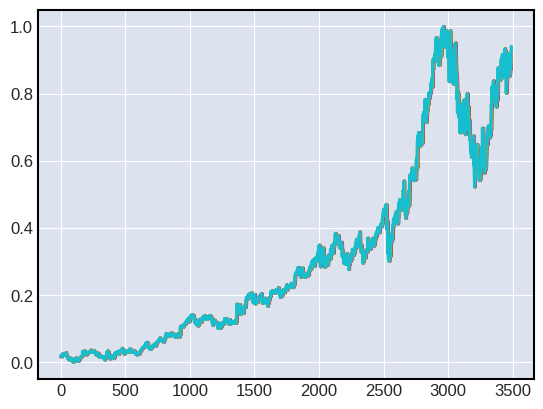

In [30]:
plt.plot(X[0])

In [63]:
def mean_absolute_percentage_error(y_true, y_pred):
    # Replace zeros in y_true with a small value to avoid division by zero
    mask = y_true != 0
    y_true[mask] += 1e-10

    # Calculate absolute percentage error
    ape = np.abs((y_true - y_pred) / y_true)

    # Replace inf values with NaN and then drop NaN
    ape[np.isinf(ape)] = np.nan
    ape = ape[~np.isnan(ape)]

    # Calculate mean absolute percentage error
    mape = np.mean(ape) * 100

    return mape


In [80]:
seed = 101

np.random.seed(seed)
keras.utils.set_random_seed(seed)


# Iterate over the first dimension (instances) of your data
for j, (train_index, test_index) in enumerate(tss.split(X[0])):
    X_train, X_test = X[j, train_index, :], X[j, test_index, :]
    y_train, y_test = Y[j, train_index], Y[j, test_index]

    # Dynamically determine the size of the third dimension
    input_shape = (X_train.shape[0], 1, X_train.shape[1])
    output_shape = (X_test.shape[0], 1, X_test.shape[1])

    trainX = np.reshape(X_train, input_shape)
    testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # LSTM model
    lstm_model = Sequential(name='LSTM')
    lstm_model.add(LSTM(64, input_shape=(None, window_size)))
    lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')


    lstm_model.fit(np.reshape(X_train, input_shape), y_train,
                   verbose=0, epochs=100)

    # Evaluate the LSTM model on the test set
    lstm_pred = lstm_model.predict(np.reshape(X_test, output_shape))
    lstm_mae = mean_absolute_error(y_test, lstm_pred)
    lstm_mse = mean_squared_error(y_test, lstm_pred)
    lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)
    print(f'Results for {My_Tickers[j]} (LSTM) = MAE: {lstm_mae}, MSE: {lstm_mse}, MAPE: {lstm_mape}')

    # Bi-LSTM model
    bi_lstm_model = Sequential(name='Bi_LSTM')
    bi_lstm_model.add(Bidirectional(LSTM(64, input_shape=(None, window_size))))
    bi_lstm_model.add(Dense(32))
    bi_lstm_model.add(Dense(1))
    bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

    bi_lstm_model.fit(np.reshape(X_train, input_shape), y_train,
                      verbose=0, epochs=100)

    # Evaluate the Bi-LSTM model on the test set
    bi_lstm_pred = lstm_model.predict(np.reshape(X_test, output_shape))
    bi_lstm_mae = mean_absolute_error(y_test, bi_lstm_pred)
    bi_lstm_mse = mean_squared_error(y_test, bi_lstm_pred)
    bi_lstm_mape = mean_absolute_percentage_error(y_test, bi_lstm_pred)
    print(f'Results for {My_Tickers[j]} (Bi-LSTM) = MAE: {bi_lstm_mae}, MSE: {bi_lstm_mse}, MAPE: {bi_lstm_mape}')

    # GRU model
    gru_model = Sequential(name='GRU')
    gru_model.add(GRU(64, input_shape=(None, window_size)))
    gru_model.add(Dense(32))
    gru_model.add(Dense(1))
    gru_model.compile(loss='mean_squared_error', optimizer='adam')

    gru_model.fit(np.reshape(X_train, input_shape), y_train,
                  verbose=0, epochs=100)

    # Evaluate the GRU model on the test set
    gru_pred = gru_model.predict(np.reshape(X_test, output_shape))
    gru_mae = mean_absolute_error(y_test, gru_pred)
    gru_mse = mean_squared_error(y_test, gru_pred)
    gru_mape = mean_absolute_percentage_error(y_test, gru_pred)
    print(f'Results for {My_Tickers[j]} (GRU) = MAE: {gru_mae}, MSE: {gru_mse}, MAPE: {gru_mape}')


19/19 [==============================] - 0s 2ms/step
Results for GOOGL (LSTM) = MAE: 0.001979324220386387, MSE: 7.439294101410937e-06, MAPE: 60.37717202007684
19/19 [==============================] - 0s 2ms/step
Results for GOOGL (Bi-LSTM) = MAE: 0.001979324271505148, MSE: 7.439294371976412e-06, MAPE: 60.37717185979449
19/19 [==============================] - 0s 2ms/step
Results for GOOGL (GRU) = MAE: 0.0018692341030537578, MSE: 6.891155453428124e-06, MAPE: 60.33975228655704
19/19 [==============================] - 0s 2ms/step
Results for AAPL (LSTM) = MAE: 0.0022341887097116885, MSE: 7.840365077332717e-06, MAPE: 14.16482090973184
19/19 [==============================] - 0s 2ms/step
Results for AAPL (Bi-LSTM) = MAE: 0.002234188765993959, MSE: 7.840365377343181e-06, MAPE: 14.164820896115355
19/19 [==============================] - 0s 2ms/step
Results for AAPL (GRU) = MAE: 0.0017171492201801734, MSE: 5.493882000300892e-06, MAPE: 14.304432916578328
19/19 [==============================] -

In [81]:
seed = 101

np.random.seed(seed)
keras.utils.set_random_seed(seed)

# Iterate over the first dimension (instances) of your data
for j, (train_index, test_index) in enumerate(tss.split(X[0])):
    X_train, X_test = X[j, train_index, :], X[j, test_index, :]
    y_train, y_test = Y[j, train_index], Y[j, test_index]

    # MLP model
    mlp_model = Sequential(name='MLP')
    mlp_model.add(Dense(64, activation='relu', input_shape=(None, window_size)))
    mlp_model.add(Dense(32, activation='relu'))
    mlp_model.add(Dense(1))
    mlp_model.compile(loss='mean_squared_error', optimizer='adam')

    mlp_model.fit(X_train, y_train,
                  verbose=0, epochs=100)

    # Evaluate the MLP model on the test set
    mlp_pred = mlp_model.predict(X_test)
    mlp_mae = mean_absolute_error(y_test, mlp_pred)
    mlp_mse = mean_squared_error(y_test, mlp_pred)
    mlp_mape = mean_absolute_percentage_error(y_test, mlp_pred)
    print(f'Results for {My_Tickers[j]} (MLP) = MAE: {mlp_mae}, MSE: {mlp_mse}, MAPE: {mlp_mape}')

    # CNN model
    cnn_model = Sequential(name='CNN')
    cnn_model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(32, activation='relu'))
    cnn_model.add(Dense(1))
    cnn_model.compile(loss='mean_squared_error', optimizer='adam')

    cnn_model.fit(np.expand_dims(X_train, axis=-1), y_train,
                  verbose=0, epochs=100)

    # Evaluate the CNN model on the test set
    cnn_pred = cnn_model.predict(np.expand_dims(X_test, axis=-1))
    cnn_mae = mean_absolute_error(y_test, cnn_pred)
    cnn_mse = mean_squared_error(y_test, cnn_pred)
    cnn_mape = mean_absolute_percentage_error(y_test, cnn_pred)
    print(f'Results for {My_Tickers[j]} (CNN) MAE: {cnn_mae}, MSE: {cnn_mse}, MAPE: {cnn_mape}')

    # Conv-LSTM model
    convlstm_model = Sequential(name='Conv_LSTM')
    convlstm_model.add(ConvLSTM2D(64, kernel_size=(1, 1), activation='relu', input_shape=(1, window_size, 1, 1)))
    convlstm_model.add(Flatten())
    convlstm_model.add(Dense(32, activation='relu'))
    convlstm_model.add(Dense(1))
    convlstm_model.compile(loss='mean_squared_error', optimizer='adam')

    convlstm_model.fit(np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1, 1)), y_train,
                       verbose=0, epochs=100)

    # Evaluate the Conv-LSTM model on the test set
    convlstm_pred = convlstm_model.predict(np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1, 1)))
    convlstm_mae = mean_absolute_error(y_test, convlstm_pred)
    convlstm_mse = mean_squared_error(y_test, convlstm_pred)
    convlstm_mape = mean_absolute_percentage_error(y_test, convlstm_pred)
    print(f'Results for {My_Tickers[j]} (Conv_LSTM) MAE: {convlstm_mae}, MSE: {convlstm_mse}, MAPE: {convlstm_mape}')


19/19 [==============================] - 0s 2ms/step
Results for GOOGL (MLP) = MAE: 0.012891458265590655, MSE: 0.00024201043564159403, MAPE: 52.090879626579664
19/19 [==============================] - 0s 2ms/step
Results for GOOGL (CNN) MAE: 0.0018287768245462822, MSE: 6.524581020940511e-06, MAPE: 61.753508502201484
19/19 [==============================] - 0s 2ms/step
Results for GOOGL (Conv_LSTM) MAE: 0.006710878374700675, MSE: 6.846129280699124e-05, MAPE: 56.06940259587524
19/19 [==============================] - 0s 2ms/step
Results for AAPL (MLP) = MAE: 0.005513229609039931, MSE: 4.368928291554743e-05, MAPE: 13.018528182454428
19/19 [==============================] - 0s 2ms/step
Results for AAPL (CNN) MAE: 0.0030520553617748437, MSE: 1.3278378541898914e-05, MAPE: 13.8095320393731
19/19 [==============================] - 0s 2ms/step
Results for AAPL (Conv_LSTM) MAE: 0.005667974851022326, MSE: 4.222143207434091e-05, MAPE: 13.322111250594029
19/19 [==============================] - 0s 

In [83]:
def naive_forecast(input_data, forecast_period=1):
    last_observation = input_data[-1]
    forecast = [last_observation[:2]] * forecast_period  # Take only the first two elements of the last observation
    return forecast

In [86]:
def naive_forecast(input_data, forecast_period=1):
    last_observation = input_data[-1]
    forecast = [last_observation] * forecast_period
    return forecast


for j, (train_index, test_index) in enumerate(tss.split(X[0])):
    X_train, X_test = X[j, train_index, :], X[j, test_index, :]
    y_train, y_test = Y[j, train_index], Y[j, test_index]

    # Use naive_forecast to make predictions
    naive_pred = naive_forecast(y_train, forecast_period=len(y_test))

    # Calculate MSE, MAE, and MAPE for naive forecast
    naive_mse = mean_squared_error(y_test, naive_pred)
    naive_mae = mean_absolute_error(y_test, naive_pred)

    # Calculate MAPE for naive forecast
    naive_mape = mean_absolute_percentage_error(y_test, naive_pred)

    print(f'Naive Forecast MSE: {naive_mse}, MAE: {naive_mae}, MAPE: {naive_mape}')



Naive Forecast MSE: 0.005349507964260578, MAE: 0.06399070917950683, MAPE: 66.7747993568598
Naive Forecast MSE: 0.0004552266469268926, MAE: 0.017930847767179684, MAPE: 15.200229607696345
Naive Forecast MSE: 0.033915069720229646, MAE: 0.15293857671453084, MAPE: 37.63660290786843
Naive Forecast MSE: 0.05489476588932066, MAE: 0.19250643950191706, MAPE: 34.85854279578399
Naive Forecast MSE: 0.20550485581834732, MAE: 0.39879065724496326, MAPE: 94.50295864841638


# Without normalization

In [89]:
Raw_Price_For_My_Tickers_filled = pd.DataFrame(data, columns=Raw_Price_For_My_Tickers_filled.columns)

In [90]:
X = []
Y = []
window_size = 10

for ticker_indx, ticker_name in enumerate(My_Tickers):
  X_time_series = []
  Y_time_series = []

  # Access the DataFrame directly using the ticker_name
  current_ticker_data = Raw_Price_For_My_Tickers_filled[ticker_name]

  # Print the length of current_ticker_data for debugging
  print(f"Length of {ticker_name} data: {len(current_ticker_data)}")

  for i in range(window_size, len(data[ticker_name])):
    X_time_series.append( data[ticker_name]['Close'][i - window_size:i])
    Y_time_series.append( data[ticker_name]['Close'][i])

  X_time_series = np.array(X_time_series)
  Y_time_series = np.array(Y_time_series)

  # Print the shape of X_time_series and Y_time_series for debugging
  print(f"Shape of X_time_series: {X_time_series.shape}")
  print(f"Shape of Y_time_series: {Y_time_series.shape}")

  X.append(X_time_series[31 - window_size:])
  Y.append(Y_time_series[31 - window_size:])

print(len(X[0]))
print(len(Y[0]))

Length of GOOGL data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of AAPL data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of AMZN data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of MSFT data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
Length of META data: 3521
Shape of X_time_series: (3511, 10)
Shape of Y_time_series: (3511,)
3490
3490


In [92]:
X = np.array(X)
Y = np.array(Y)

In [93]:
seed = 101

np.random.seed(seed)
keras.utils.set_random_seed(seed)


# Iterate over the first dimension (instances) of your data
for j, (train_index, test_index) in enumerate(tss.split(X[0])):
    X_train, X_test = X[j, train_index, :], X[j, test_index, :]
    y_train, y_test = Y[j, train_index], Y[j, test_index]

    # Dynamically determine the size of the third dimension
    input_shape = (X_train.shape[0], 1, X_train.shape[1])
    output_shape = (X_test.shape[0], 1, X_test.shape[1])

    trainX = np.reshape(X_train, input_shape)
    testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    # LSTM model
    lstm_model = Sequential(name='LSTM')
    lstm_model.add(LSTM(64, input_shape=(None, window_size)))
    lstm_model.add(Dense(32))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')


    lstm_model.fit(np.reshape(X_train, input_shape), y_train,
                   verbose=0, epochs=100)

    # Evaluate the LSTM model on the test set
    lstm_pred = lstm_model.predict(np.reshape(X_test, output_shape))
    lstm_mae = mean_absolute_error(y_test, lstm_pred)
    lstm_mse = mean_squared_error(y_test, lstm_pred)
    lstm_mape = mean_absolute_percentage_error(y_test, lstm_pred)
    print(f'Results for {My_Tickers[j]} (LSTM) = MAE: {lstm_mae}, MSE: {lstm_mse}, MAPE: {lstm_mape}')

    # Bi-LSTM model
    bi_lstm_model = Sequential(name='Bi_LSTM')
    bi_lstm_model.add(Bidirectional(LSTM(64, input_shape=(None, window_size))))
    bi_lstm_model.add(Dense(32))
    bi_lstm_model.add(Dense(1))
    bi_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

    bi_lstm_model.fit(np.reshape(X_train, input_shape), y_train,
                      verbose=0, epochs=100)

    # Evaluate the Bi-LSTM model on the test set
    bi_lstm_pred = lstm_model.predict(np.reshape(X_test, output_shape))
    bi_lstm_mae = mean_absolute_error(y_test, bi_lstm_pred)
    bi_lstm_mse = mean_squared_error(y_test, bi_lstm_pred)
    bi_lstm_mape = mean_absolute_percentage_error(y_test, bi_lstm_pred)
    print(f'Results for {My_Tickers[j]} (Bi-LSTM) = MAE: {bi_lstm_mae}, MSE: {bi_lstm_mse}, MAPE: {bi_lstm_mape}')

    # GRU model
    gru_model = Sequential(name='GRU')
    gru_model.add(GRU(64, input_shape=(None, window_size)))
    gru_model.add(Dense(32))
    gru_model.add(Dense(1))
    gru_model.compile(loss='mean_squared_error', optimizer='adam')

    gru_model.fit(np.reshape(X_train, input_shape), y_train,
                  verbose=0, epochs=100)

    # Evaluate the GRU model on the test set
    gru_pred = gru_model.predict(np.reshape(X_test, output_shape))
    gru_mae = mean_absolute_error(y_test, gru_pred)
    gru_mse = mean_squared_error(y_test, gru_pred)
    gru_mape = mean_absolute_percentage_error(y_test, gru_pred)
    print(f'Results for {My_Tickers[j]} (GRU) = MAE: {gru_mae}, MSE: {gru_mse}, MAPE: {gru_mape}')


19/19 [==============================] - 1s 3ms/step
Results for GOOGL (LSTM) = MAE: 0.001979324220386387, MSE: 7.439294101410937e-06, MAPE: 60.37717202007684
19/19 [==============================] - 0s 3ms/step
Results for GOOGL (Bi-LSTM) = MAE: 0.001979324271505148, MSE: 7.439294371976412e-06, MAPE: 60.37717185979449
19/19 [==============================] - 1s 3ms/step
Results for GOOGL (GRU) = MAE: 0.0018692341030537578, MSE: 6.891155453428124e-06, MAPE: 60.33975228655704
19/19 [==============================] - 1s 2ms/step
Results for AAPL (LSTM) = MAE: 0.0022341887097116885, MSE: 7.840365077332717e-06, MAPE: 14.16482090973184
19/19 [==============================] - 0s 3ms/step
Results for AAPL (Bi-LSTM) = MAE: 0.002234188765993959, MSE: 7.840365377343181e-06, MAPE: 14.164820896115355
19/19 [==============================] - 0s 2ms/step
Results for AAPL (GRU) = MAE: 0.0017171492201801734, MSE: 5.493882000300892e-06, MAPE: 14.304432916578328
19/19 [==============================] -

KeyboardInterrupt: ignored

As it could be seen from the results above not performing normalization has had a negative effect on the performance of the models. This happens cause of the actication functions like Tanh and sigmoid whcih are use in our models arcitecture. Also if we were using more features (other than close) the different scale of the features would have affected the performance. Without normalizing the importance of some features would have been different while bulding the model and all of them wouldn't have been treated equally.